# Neural Networks to Solve Flow PDEs

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


# First a code to solve a simple ODE
A simple ODE problem is

$\frac{dy}{dx} = \cos(x)$,

$y(x=0) = 0$.

Of course the answer to this problem is
$y = \sin(x)$

But can a neural network learn this solution without knowing anything but the ODE and the boundary condition?


In [4]:
# Model

class PDENeuralNet(tf.keras.Model):
  def __init__(self, n_inputs, n_outputs):
    super().__init__()
    
    self.n_inputs = n_inputs
    self.n_outputs = n_outputs
  
    self.nn_model = tf.keras.Sequential([
      Dense(100, activation=tf.nn.elu),
      Dense(100, activation=tf.nn.elu),
      Dense(40, activation=tf.nn.elu),
      Dense(30, activation=tf.nn.elu),
      Dense(10, activation=tf.nn.elu),
      Dense(self.n_outputs, activation=None), # No activation last layer matches PINN paper
    ])

    self(tf.zeros([1, self.n_inputs]))  # dummy call to build the model

  @tf.function
  def call(self, x):
    z = self.nn_model(x)
    return z

In [5]:

# Neural network parameters
N_INPUTS = 1
N_OUTPUTS = 1

# Additional parameters
N_QUERY = 100
N_ITER = 5000



In [6]:
nn = PDENeuralNet(N_INPUTS,N_OUTPUTS)

In [7]:
output = nn(tf.ones([3, N_INPUTS]))
print(output)

tf.Tensor(
[[0.14891799]
 [0.14891799]
 [0.14891799]], shape=(3, 1), dtype=float32)


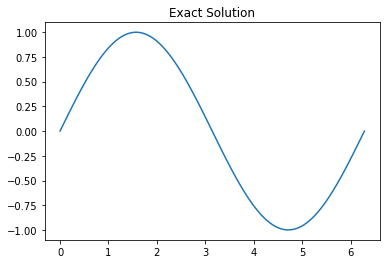

In [8]:
x = np.linspace(0,2*np.pi,N_QUERY)[:,np.newaxis] # N_QUERY x 1 (need to modify if N_INPUTS > 1)
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
plt.plot(x,np.sin(x))
plt.title("Exact Solution")
plt.show()

In [9]:
# Set up optimizer
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [500], [lr, lr * 0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

def train(model, x):
  for i in range(N_ITER):
    with tf.GradientTape(persistent=True) as t:
      #import pdb; pdb.set_trace()
      t.watch(x)
      y = model(x)
      dydx = t.gradient(y, x)
      loss_boundary = tf.square(tf.squeeze(y[0])) # First element should be for x = 0
      loss_pde = tf.reduce_mean(tf.square(tf.math.cos(x) - dydx))
      loss = loss_boundary + loss_pde
      
    gradients = t.gradient(loss, model.weights)

    # Apply gradients
    trainer.apply_gradients(zip(gradients, model.weights))
    if i % 100 == 0:
      print(f"Step {i} loss is {loss}")
    

In [10]:
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
train(nn, x_tensor)

Step 0 loss is 0.4701911509037018
Step 100 loss is 0.0003602099895942956
Step 200 loss is 0.00022961986542213708
Step 300 loss is 0.0011875227792188525
Step 400 loss is 0.000667769112624228
Step 500 loss is 0.00036552976234816015
Step 600 loss is 0.000119750875455793
Step 700 loss is 0.00011284489301033318
Step 800 loss is 0.00010857126471819356
Step 900 loss is 0.00010479625052539632
Step 1000 loss is 0.00010182119876844808
Step 1100 loss is 9.941306052496657e-05
Step 1200 loss is 9.72002453636378e-05
Step 1300 loss is 9.510447853244841e-05
Step 1400 loss is 9.309501183452085e-05
Step 1500 loss is 9.112176485359669e-05
Step 1600 loss is 8.918869571061805e-05
Step 1700 loss is 8.72845048434101e-05
Step 1800 loss is 8.53725869092159e-05
Step 1900 loss is 8.350171992788091e-05
Step 2000 loss is 8.171124500222504e-05
Step 2100 loss is 7.988382276380435e-05
Step 2200 loss is 7.809872477082536e-05
Step 2300 loss is 7.641017873538658e-05
Step 2400 loss is 7.484973320970312e-05
Step 2500 loss

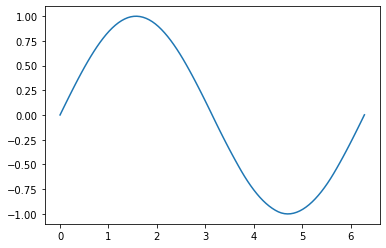

In [11]:
def plot_nn(model, x_tensor):
  y = model(x_tensor).numpy()
  plt.plot(x_tensor.numpy(), y)
N_TEST = 100
test = np.linspace(0,2*np.pi,N_TEST)[:,np.newaxis] # N_QUERY x 1 (need to modify if N_INPUTS > 1)
test_tensor = tf.convert_to_tensor(test, dtype=tf.float32)
plot_nn(nn, test_tensor) 
  

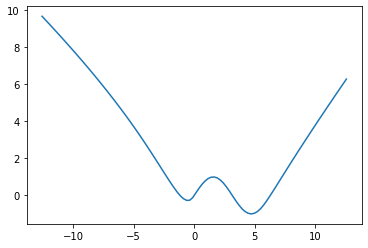

In [12]:
x2 = np.linspace(-4*np.pi,4*np.pi,100)[:,np.newaxis] # N_QUERY x 1 (need to modify if N_INPUTS > 1)
x2_tensor = tf.convert_to_tensor(x2, dtype=tf.float32)
plot_nn(nn, x2_tensor)

# Basic conduit flow

We want to solve the following equations, for non-dimensional basic conduit flow

\begin{eqnarray}
&\frac{\partial}{\partial y^*}\left(\rho^* u^*\right) = 0 \\
&\rho^* u^*\frac{\partial u^*}{\partial y^*} = -\frac{\partial p^*}{\partial y^*} - \frac{1}{\mathrm{Fr}^2}\rho^* - \tau^* \\
&\rho_g^* = p^* \\
&\tau^* = \begin{cases} 
      f_0\rho^* (u^*)^2 \frac{L}{R} & \phi > \phi_f \\
      \frac{1}{\mathrm{Re}}8u^* &  \phi \le \phi_f
   \end{cases}
\end{eqnarray}
where $\rho^* = (1-\phi + \delta \phi\rho_g^*)$, $\delta = \frac{\rho_{g0}}{\rho_l}$, and we have made use of the following non-dimensional numbers,
\begin{eqnarray}
  &\mathrm{Fr} = \frac{u_0}{\sqrt{Lg}}\\
  &\mathrm{Re} = \frac{R^2 \rho_l u_0}{L \mu}.
\end{eqnarray}

In addition we have the boundary conditions
\begin{eqnarray}
&p^*(y^*=0) = 1 \\
&p^*(y^*=1) = 0 \\
\end{eqnarray}

Thus we propose a neural network with one input ($y^*$) and two outputs ($p^*$ and $u^*$). The governing equations and boundary conditions will be included in the loss function. 

In [13]:
# Model parameters
A = {}
A['f0'] = 0.01         # Darcy-Weisbach friction factor
A['phi0'] = 0.75       # critical gas volume fraction for fragmentation
A['L'] = 4000.0         # Length of conduit
A['r'] = 20.0            # Radius of conduit
A['g'] = 9.8           # Gravity
A['rhol'] = 2700.0       # Density of melt
A['rhor'] = 2700.0       # Density of rock
A['p0'] = A['rhor']*A['L']*A['g']     # Chamber pressure
A['mu'] = 100000.0          # Viscosity (vals tried = 1e3, 1e4, 1e5, 1e6)
A['x0'] = 0.05         # Mass fraction of volatiles (assumed always exsolved)
A['u0'] = (A['p0']/A['rhol'])**(1/2)  # Characteristic velocity
A['Rw'] = 461.5        # Specific gas constant
A['T'] = 900.0           # Temperature
A['rhog0'] = A['p0']/(A['Rw']*A['T']) # Characteristic gas density

A['Fr'] = A['u0']/(A['L']*A['g'])**(1/2)        # Froude number
A['Re'] = (A['r']**2)*A['rhol']*A['u0']/(A['L']*A['mu'])  # Reynolds number
A['delta'] = A['rhog0']/A['rhol']          # Ratio of characteristic densities

In [14]:

# Neural network parameters
N_INPUTS = 1
N_OUTPUTS = 2

# Hyper-parameters
N_QUERY = 100
N_ITER = 50000
N_DATA_STEPS = 2000


In [15]:
conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS) # First output is pressure, second is u

In [16]:
eps = 1e-2
y = np.linspace(0+eps,1-eps,N_QUERY)[:,np.newaxis] # returns a np.array that is size (N_QUERY x 1)

In [17]:
y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
v = conduit_nn(y_tensor)

In [18]:
## Get numerics answer from matlab
import matlab
import matlab.engine

eng = matlab.engine.start_matlab()

path = '/home/bmullet/Research/MATLAB_software/conduit/erupt/'
eng.addpath (path, nargout= 0 )

In [19]:

query_matlab = matlab.double(y.tolist())
[p,u, dpdy, dudy, B] = eng.get_simple_eruption(A,query_matlab, nargout=5);

def mat_to_py(var):
  # converts matlab arrays to numpy arrays and makes sure everything is shape Nx1
  val = np.array(var)
  if len(val.shape) < 2:
    val = val[:,np.newaxis]
  L, W = val.shape
  if L < W:
    val = val.T
  return val

pmat = mat_to_py(p)
umat = mat_to_py(u)
ymat = mat_to_py(y)
dpdymat = mat_to_py(dpdy)
dudymat = mat_to_py(dudy)

mat = {"p": pmat, "u" : umat, "dpdy" : dpdymat, "dudy" : dudymat}


## This is where Ying Qi should look for the model set up

YQ will implement function like "get_conduit_vals" for her conduit flow problem

In [21]:
# DUMMY CODE FOR YING QI'S MODEL

def get_yq_conduit_vals(p, v, phi_g, m_b, A):
  """Get derived values, given the primary variables
  Input
    p: (Nx1) tf.tensor for pressure
    v: (Nx1) tf.tensor for velocity
    phi_g: (Nx1) tf.tensor for gas volume fraction
    m_b: (Nx1) tf.tensor for mole fraction of exsolved h2o
    A: dict of constants for computing conduit values
  Output
    derived_vals_dict: dict of (Nx1) tf.tensors for derived conduit values
  """
  
  # remove this once implemented
  raise NotImplementedError
  
  # Notes: 
  # - Tensors can (almost always) use the same operations as numpy
  #   arrays, so just code this like you were coding a function for 
  #   numpy arrays
  # - In the example code (below), the dict A contains scalar constants that are
  #   used for calculating the derived values. In practice, we can
  #   make this dict contain anything we want, like arrays of constants
  #   that are the same size as the primary variable arrays being passed in.
  #   This might be useful if some constants change between model runs, 
  #   like conduit radius.
  
  #####################################
  #
  #           YING QI'S CODE HERE
  #
  #####################################
  
  ## Final bit of code might look something like this.
  ## Basically collecting all the "dependent variables" in your paper Table 1
  
  #   derived_vals_dict = {
  #     "c1" : c1,
  #     "k_mag" : k_mag,
  #     ....
  #   }
  
  return derived_vals_dict
  
  

In [22]:


def get_optimzer(type="Adam"):
  """Sets up NN model optimizer"""
  lr = 2e-3
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [500], [lr, lr * 0.1])
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
  if type=="Adam":
    trainer = tf.keras.optimizers.Adam(lr_schedule)
  else:
    lr = 6e-7 #too high [2e-6] too low [2e-7] 7e-7 is OK
    lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
          [500], [lr, lr * 0.1])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
    trainer = tf.keras.optimizers.SGD(learning_rate = lr)
  return trainer

trainer = get_optimzer()

def get_conduit_vals(p, u, A):
  """Get derived values, given the primary variables
  Input
    p: (Nx1) tensor for pressure
    u: (Nx1) tensor for velocity
    A: dict of constants for computing conduit values
  Output
    (Nx1) tensors for derived conduit values
    
  """
  
  rhog = p # Nondimensionalized
  phi = 1/(1 + (1-A['x0'])/(A['x0'])*(A['delta']*rhog))
  rho = (1-phi+A['delta']*phi*rhog)
  
  post_frag = (tf.cast(phi > A['phi0'], phi.dtype))
  pre_frag = 1.0 - post_frag
  
  tau_turbulent = A['f0']*rho*u*u*A['L']/A['r']
  tau_viscous = 8/A['Re']*(u)
  
  tau = tau_turbulent*post_frag + tau_viscous*pre_frag
  
  rhog = p
  
  beta = 1/A['delta']*A['x0']/(1+A['x0'])*(rho/rhog)**2
  
  return phi, rho, tau, rhog, beta

def split_tensor(tensor):
  """Splits NxM tensor into M Nx1 dimensional tensors"""
  vectors = tf.unstack(tensor,axis=1)
  for v in vectors:
    yield v[:,None]
  
  
def simple_conduit_loss(y, outputs, dvdy, A, iteration):
  """Calculate the loss function"""
  
  # Split outputs from the neural network model
  p, u = split_tensor(outputs)
      
  # Retrieve gradients from the neural network model
  dpdy, dudy = dvdy

  # Get derived values
  # *********Ying Qi: This is where your code would plug in ****
    
  phi, rho, tau, rhog, beta = get_conduit_vals(p, u, A)
  
  # *************************************************************

  # Calculate "physics-informed" values for gradients
  # (These are the values that the gradients should take if they 
  # satisfy the governing equations)
  dpdy0 = -(tau+rho/A['Fr']**2)/(1-(u**2)*beta)
  dudy0 = -u/rho*beta*dpdy0
  
  # Start training by just trying to match the matlab output
  if iteration < N_DATA_STEPS:
    loss_p = tf.reduce_mean(tf.square(p - mat["p"]))
    loss_u = tf.reduce_mean(tf.square(u - mat["u"]))
    loss_dudy = tf.reduce_mean(tf.square(dudy - (mat["dudy"])))
    loss_dpdy = tf.reduce_mean(tf.square(dpdy - (mat["dpdy"])))
    
  # After a certain number of steps, switch to a "physics-informed" loss
  else:
    # Boundary conditions
    # pressure should be 1 at the chamber, some nominal atmospheric value at the surface
    loss_p = tf.squeeze(tf.square(p[0] - 1)) + tf.squeeze(tf.square(p[-1] - 0.1))
    # no BCs for u
    loss_u = 0

    # PDEs
    loss_dudy = tf.abs(dudy - dudy0)
    loss_dudy = tf.reduce_mean(loss_dudy)

    loss_dpdy = tf.abs(dpdy - dpdy0)
    loss_dpdy = tf.reduce_mean(loss_dpdy)
      
  loss = loss_p + loss_u + loss_dudy + loss_dpdy
  
  plot_vars = {"y": y, "p" : p, "u" : u, "dpdy" : dpdy, "dudy" : dudy, "A" : A, "p0" : mat["p"], "u0" : mat["u"], "dpdy0": dpdy0, "dudy0":dudy0}
  return loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars
      
def train(model, y, A, mat, loss_func):
  trainer = get_optimzer()
  
  # Iterate over epochs
  for i in range(N_ITER):
    with tf.GradientTape(persistent=True) as t:
      t.watch(y)
      
      # forward pass of the model
      v = model(y)

      outs = [tensor for tensor in split_tensor(v)]
      
      # get gradients with respect to y
      dvdy = []
      for j in range(len(outs)):
        dvdy.append(t.gradient(outs[j],y))

      # Calculate loss
      loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars = loss_func(y, v, dvdy, A, i)
 
    # Get gradients for model
    gradients = t.gradient(loss, model.weights)

    if i == N_DATA_STEPS:
      # Switch to new optimzer when we switch loss functions (see loss definition)
      trainer = get_optimzer("SGD")
  
    # Apply gradients to model
    trainer.apply_gradients(zip(gradients, model.weights))
 
    # Plot every so often
    if i % 1000 == 0:
      
      print(f"Step {i} loss is {loss}")
      print(f"u loss is {loss_u}")
      print(f"p loss is {loss_p}")
      print(f"dudy loss is {loss_dudy}")
      print(f"dpdyloss is {loss_dpdy}")
      
      plot(**plot_vars)

def plot(y,p,u,dpdy,dudy,A,p0=None,u0 = None,dpdy0=None, dudy0=None):
  """Simple plots for the simple conduit"""
  y = np.array(y)
  p = np.array(p)
  u = np.array(u)
  plt.figure(figsize=(15, 3))
  plt.subplot(141)
  plt.plot(y, p, label="model")
  plt.xlabel("y")
  plt.ylabel("p")
  if p0 is not None:
    plt.plot(y,p0,'--r', label="matlab")
  plt.legend()
  plt.subplot(142)
  plt.plot(y,u)
  plt.xlabel("y")
  plt.ylabel("u")
  if u0 is not None:
    plt.plot(y,u0,'--r')
  plt.subplot(143)
  plt.plot(y,dpdy)
  plt.xlabel("y")
  plt.ylabel("dpdy")
  if dpdy0 is not None:
    plt.plot(y,dpdy0,'--r')
  plt.subplot(144)
  plt.plot(y,dudy)
  plt.xlabel("y")
  plt.ylabel("dudy")
  if dudy0 is not None:
    plt.plot(y,dudy0,'--r')
  plt.tight_layout()
  plt.show()

    

Step 0 loss is 1.307157039642334
u loss is 0.02538371831178665
p loss is 0.2969405949115753
dudy loss is 0.0641307383775711
dpdyloss is 0.9207019209861755


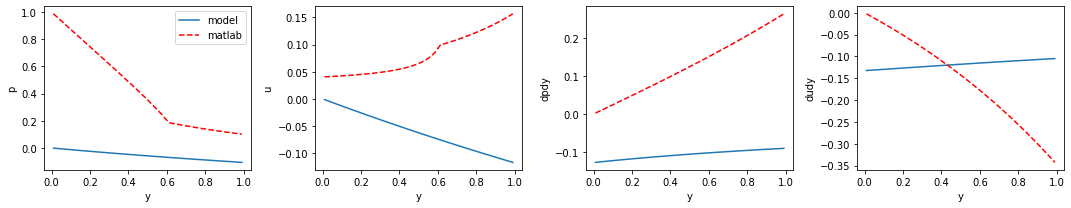

Step 1000 loss is 0.004205166362226009
u loss is 3.853713678836357e-06
p loss is 0.00018897991685662419
dudy loss is 0.0004090923466719687
dpdyloss is 0.0036032404750585556


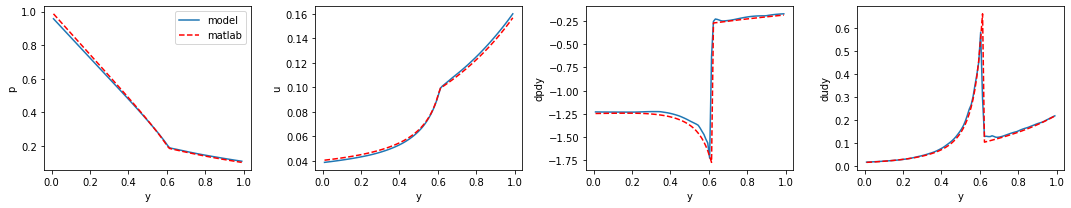

Step 2000 loss is 0.029910076409578323
u loss is 0
p loss is 0.00019280280685052276
dudy loss is 0.008209016174077988
dpdyloss is 0.02150825783610344


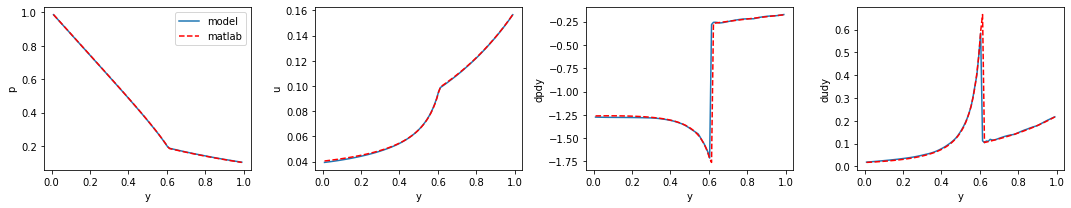

Step 3000 loss is 0.026857472956180573
u loss is 0
p loss is 0.0001315463741775602
dudy loss is 0.007092196960002184
dpdyloss is 0.01963372901082039


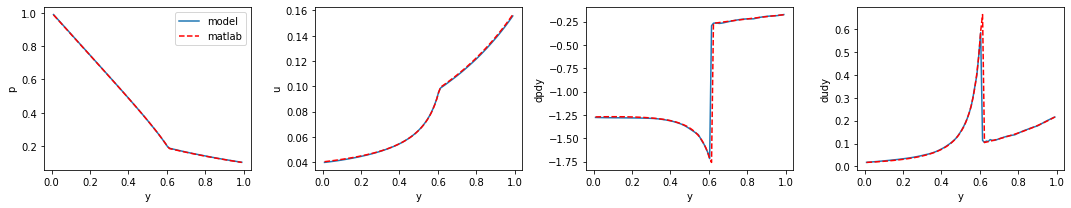

Step 4000 loss is 0.02659144625067711
u loss is 0
p loss is 0.00015865801833570004
dudy loss is 0.0070593892596662045
dpdyloss is 0.019373398274183273


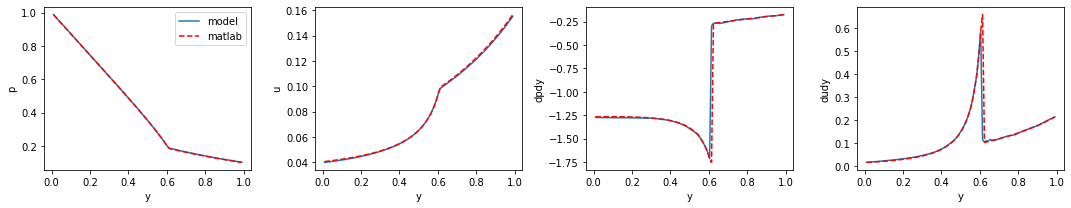

Step 5000 loss is 0.02560279704630375
u loss is 0
p loss is 0.00016287861217278987
dudy loss is 0.006900536362081766
dpdyloss is 0.01853938214480877


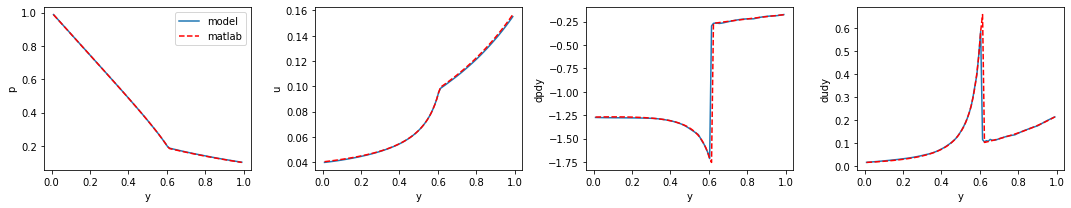

Step 6000 loss is 0.026555191725492477
u loss is 0
p loss is 0.0001655092346481979
dudy loss is 0.007147126365453005
dpdyloss is 0.019242556765675545


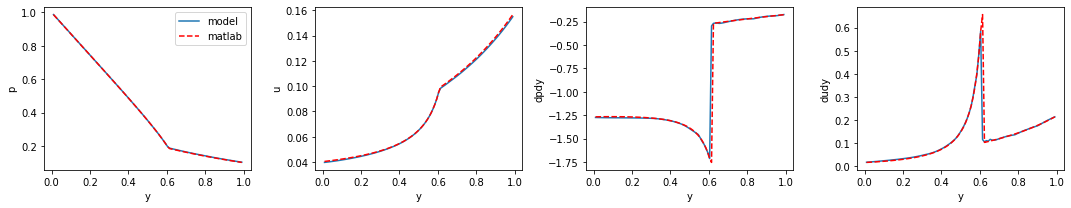

Step 7000 loss is 0.025971898809075356
u loss is 0
p loss is 0.00016553841123823076
dudy loss is 0.007052469067275524
dpdyloss is 0.018753891810774803


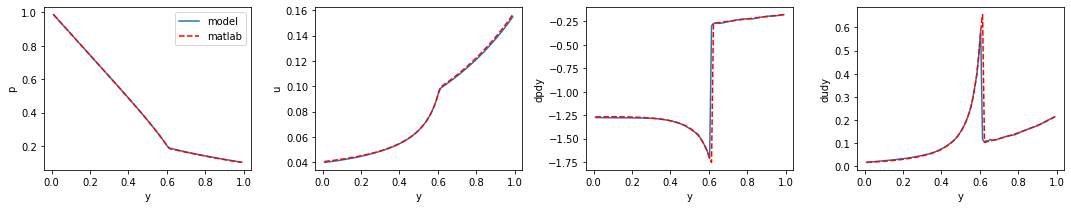

Step 8000 loss is 0.02638380229473114
u loss is 0
p loss is 0.00016316463006660342
dudy loss is 0.007153945509344339
dpdyloss is 0.019066693261265755


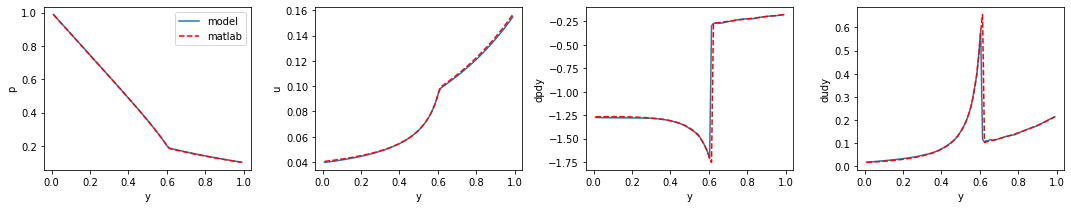

Step 9000 loss is 0.02661558985710144
u loss is 0
p loss is 0.00016106778639368713
dudy loss is 0.007210191339254379
dpdyloss is 0.019244331866502762


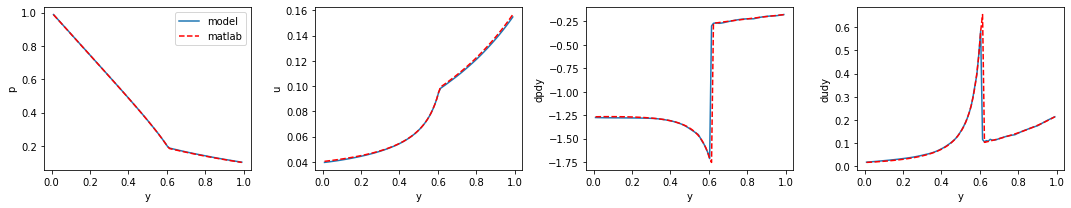

Step 10000 loss is 0.026862099766731262
u loss is 0
p loss is 0.00015977612929418683
dudy loss is 0.007269663270562887
dpdyloss is 0.019432660192251205


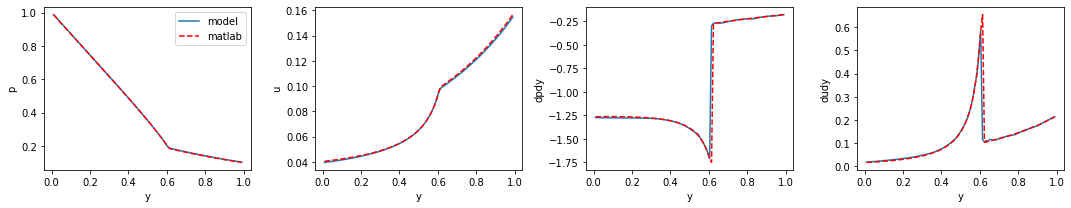

Step 11000 loss is 0.02695470117032528
u loss is 0
p loss is 0.0001584280835231766
dudy loss is 0.007296851370483637
dpdyloss is 0.01949942111968994


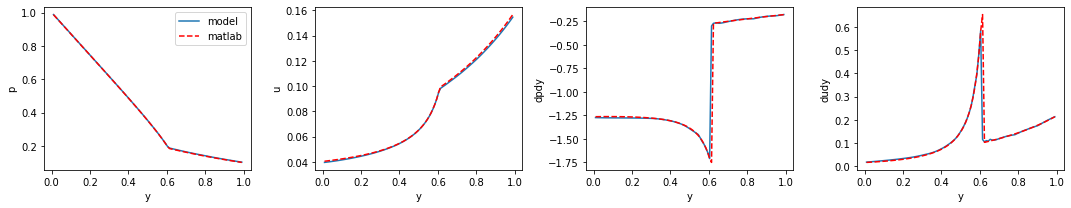

Step 12000 loss is 0.027327097952365875
u loss is 0
p loss is 0.00015651022840756923
dudy loss is 0.00738088833168149
dpdyloss is 0.019789699465036392


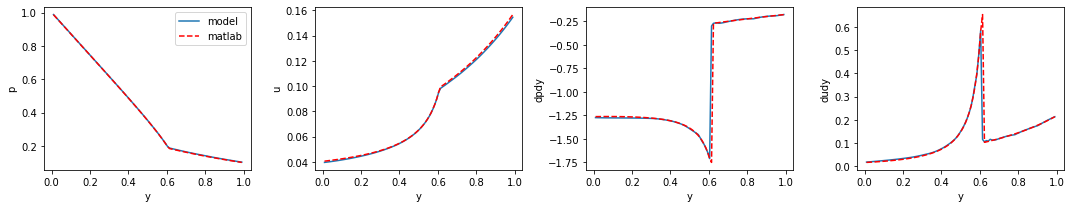

Step 13000 loss is 0.02744859829545021
u loss is 0
p loss is 0.00015430344501510262
dudy loss is 0.007411349564790726
dpdyloss is 0.019882945343852043


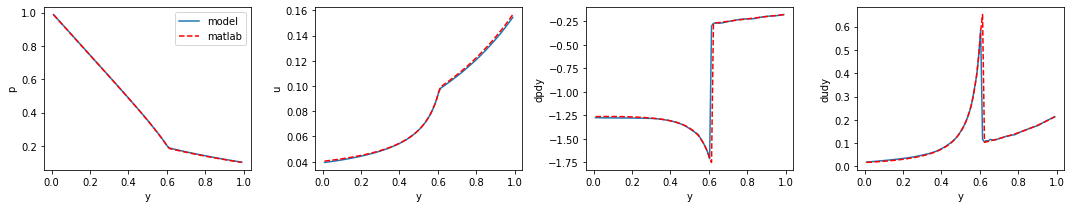

Step 14000 loss is 0.027510805055499077
u loss is 0
p loss is 0.0001508255663793534
dudy loss is 0.007412979379296303
dpdyloss is 0.019946999847888947


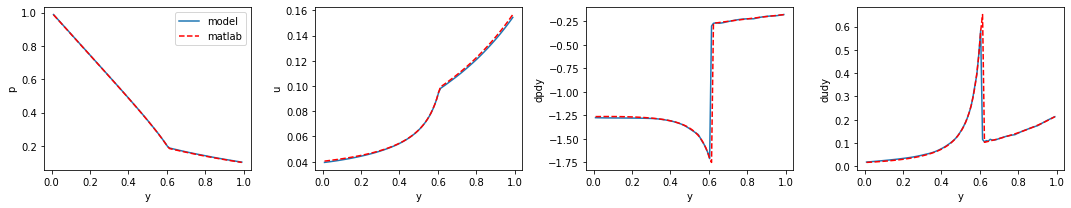

Step 15000 loss is 0.027611400932073593
u loss is 0
p loss is 0.00014758837642148137
dudy loss is 0.007419579196721315
dpdyloss is 0.0200442336499691


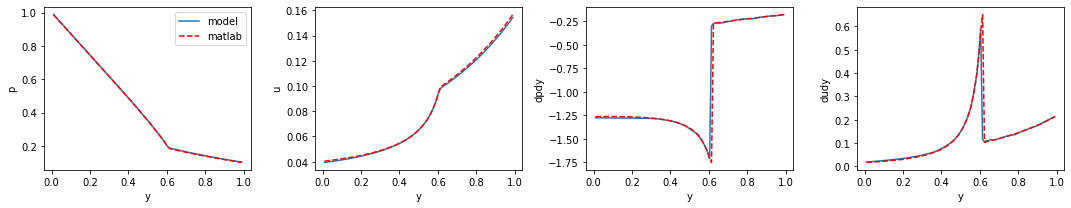

Step 16000 loss is 0.02757314033806324
u loss is 0
p loss is 0.00014465031563304365
dudy loss is 0.0073967804200947285
dpdyloss is 0.020031709223985672


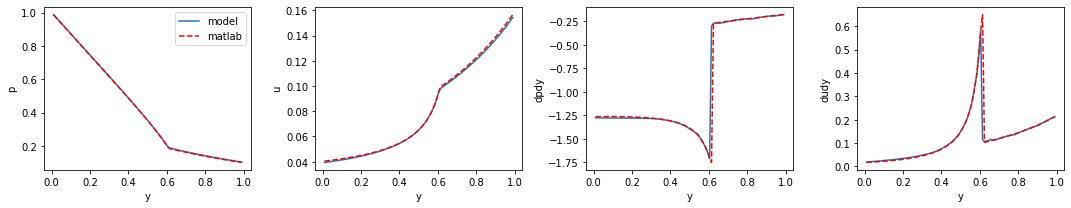

KeyboardInterrupt: 

In [23]:
conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS) # First output is pressure, second is u
train(conduit_nn, y_tensor, A, mat, simple_conduit_loss)


# Multiple parameters
Lets vary the viscosity and see if that makes any difference

For a first try, let's establish priors on viscosity over a broad range, say $\mu \in [10^3, 10^7] Pa-s$

## Try one. Use a $\log_{10}$ (viscosity)

For the purposes of the model, it's nice to have input parameters in the range [0,1]. Let's train a model that is fed two input features: the y coordinate and log_10(viscosity) (normalized by max value)

In [453]:
# Get matlab data

# Model parameters
A = {}
A['f0'] = 0.01         # Darcy-Weisbach friction factor
A['phi0'] = 0.75       # critical gas volume fraction for fragmentation
A['L'] = 4000.0         # Length of conduit
A['r'] = 20.0            # Radius of conduit
A['g'] = 9.8           # Gravity
A['rhol'] = 2700.0       # Density of melt
A['rhor'] = 2700.0       # Density of rock
A['p0'] = A['rhor']*A['L']*A['g']     # Chamber pressure
#A['mu'] = 10000000.0          # WILL BE SET AS WE COLLECT DATA
A['x0'] = 0.05         # Mass fraction of volatiles (assumed always exsolved)
A['u0'] = (A['p0']/A['rhol'])**(1/2)  # Characteristic velocity
A['Rw'] = 461.5        # Specific gas constant
A['T'] = 900.0           # Temperature

def set_nondimensional_params(A):
  # modifies A in place (no need for return value)
  A['rhog0'] = A['p0']/(A['Rw']*A['T']) # Characteristic gas density
  A['Fr'] = A['u0']/(A['L']*A['g'])**(1/2)        # Froude number
  A['Re'] = (A['r']**2)*A['rhol']*A['u0']/(A['L']*A['mu'])  # Reynolds number
  A['delta'] = A['rhog0']/A['rhol']          # Ratio of characteristic densities

MAX_MU = 6
MIN_MU = 3
NUM_MUS = 10
mu_vals = np.logspace(MIN_MU, MAX_MU, NUM_MUS)

for mu in mu_vals:
  A['mu'] = float(mu)
  set_nondimensional_params(A)
  print(A)

N_QUERY = 100
eps = 1e-2
y = np.linspace(0+eps,1-eps,N_QUERY)[:,np.newaxis] # N_QUERY x 1 (need to modify if N_INPUTS > 1)
y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
print(y_tensor.shape)

{'f0': 0.01, 'phi0': 0.75, 'L': 4000.0, 'r': 20.0, 'g': 9.8, 'rhol': 2700.0, 'rhor': 2700.0, 'p0': 105840000.00000001, 'x0': 0.05, 'u0': 197.9898987322333, 'Rw': 461.5, 'T': 900.0, 'mu': 1000.0, 'rhog0': 254.82123510292527, 'Fr': 1.0, 'Re': 53.457272657702994, 'delta': 0.09437823522330566}
{'f0': 0.01, 'phi0': 0.75, 'L': 4000.0, 'r': 20.0, 'g': 9.8, 'rhol': 2700.0, 'rhor': 2700.0, 'p0': 105840000.00000001, 'x0': 0.05, 'u0': 197.9898987322333, 'Rw': 461.5, 'T': 900.0, 'mu': 2154.4346900318847, 'rhog0': 254.82123510292527, 'Fr': 1.0, 'Re': 24.812667984338784, 'delta': 0.09437823522330566}
{'f0': 0.01, 'phi0': 0.75, 'L': 4000.0, 'r': 20.0, 'g': 9.8, 'rhol': 2700.0, 'rhor': 2700.0, 'p0': 105840000.00000001, 'x0': 0.05, 'u0': 197.9898987322333, 'Rw': 461.5, 'T': 900.0, 'mu': 4641.588833612777, 'rhog0': 254.82123510292527, 'Fr': 1.0, 'Re': 11.51702026482483, 'delta': 0.09437823522330566}
{'f0': 0.01, 'phi0': 0.75, 'L': 4000.0, 'r': 20.0, 'g': 9.8, 'rhol': 2700.0, 'rhor': 2700.0, 'p0': 105840

(100, 1) (100, 1)


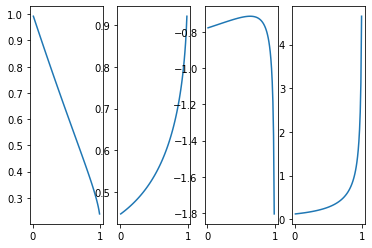

(100, 1) (100, 1)


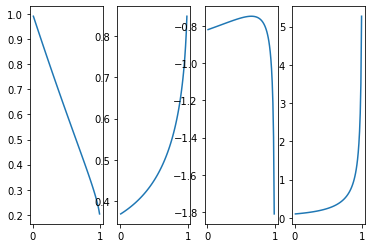

(100, 1) (100, 1)


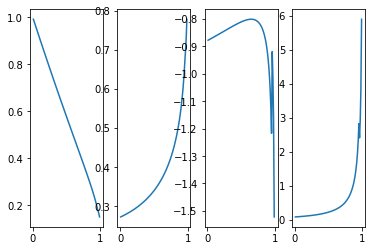

(100, 1) (100, 1)


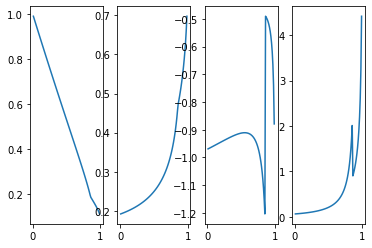

(100, 1) (100, 1)


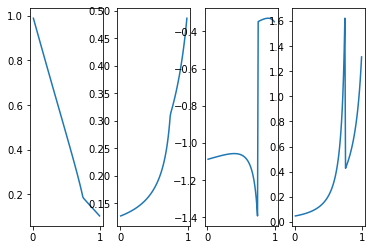

(100, 1) (100, 1)


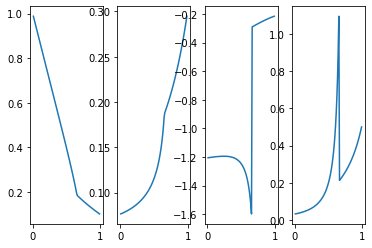

(100, 1) (100, 1)


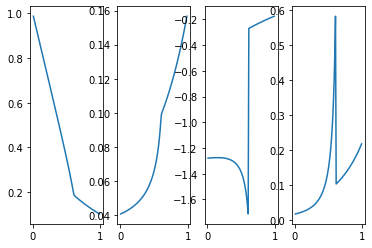

(100, 1) (100, 1)


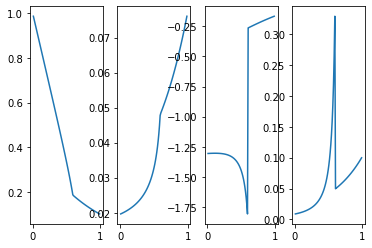

(100, 1) (100, 1)


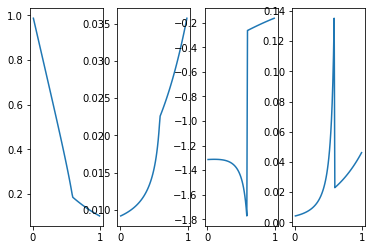

(100, 1) (100, 1)


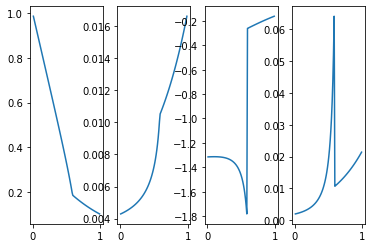

In [454]:
query_matlab = matlab.double(y.squeeze().tolist())

def mat_to_py(var):
  var = np.array(var)
  (L,W) = var.shape
  if W > L:
    var = var.T
    
  return var

pmats = []
umats = []
ymats = []
dpdymats = []
dudymats = []
mus = []

for i, mu in enumerate(mu_vals):
  A['mu'] = float(mu)
  set_nondimensional_params(A)
  [p,u, dpdy, dudy, B] = eng.get_simple_eruption(A,query_matlab, nargout=5);

  pmats.append(mat_to_py(p))
  umats.append(mat_to_py(u))
  ymats.append(mat_to_py(y))
  dpdymats.append(mat_to_py(dpdy))
  dudymats.append(mat_to_py(dudy))
  mus.append(np.ones_like(y)*np.log10(A['mu'])/MAX_MU)
  
  print(ymats[i].shape, pmats[i].shape)

  plot_vars(ymats[i],pmats[i],umats[i],dpdymats[i],dudymats[i],A)
  




In [455]:
# First let's construct the input and output (labeled) tensors
muvec = np.concatenate(mus, axis=0)
yvec = np.concatenate(ymats, axis=0)
print(muvec.shape, yvec.shape)

ins = np.concatenate([yvec, muvec], axis=1)
print(ins.shape)

# changing mu will affect the Renolds number, so change A to have a vector for Re
Re = (A['r']**2)*A['rhol']*A['u0']/(A['L']*muvec)
A['Re'] = tf.squeeze(tf.convert_to_tensor(Re, dtype=tf.float32))
print(A["Re"].shape)

pvec = np.concatenate(pmats, axis =0)
uvec = np.concatenate(umats, axis=0)
print(pvec.shape, uvec.shape)
v_true = np.concatenate([pvec, uvec], axis=1)
print(v_true.shape)

dpdyvec = np.concatenate(dpdymats, axis =0)
dudyvec = np.concatenate(dudymats, axis=0)
dvdy_true = np.concatenate([dpdyvec, dudyvec], axis=1)
print(dvdy_true.shape)


(1000, 1) (1000, 1)
(1000, 2)
(1000,)
(1000, 1) (1000, 1)
(1000, 2)
(1000, 2)


In [484]:

def get_optimzer(type="Adam"):
  lr = 2e-3
  lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [500], [lr, lr * 0.1])
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
  if type=="Adam":
    trainer = tf.keras.optimizers.Adam(lr_schedule)
  else:
    lr = 6e-7 #too high [2e-6] too low [2e-7] 7e-7 is OK
    lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
          [500], [lr, lr * 0.1])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        lr,
      decay_steps=10000,
      decay_rate=0.1,
      staircase=True)
    trainer = tf.keras.optimizers.SGD(learning_rate = lr)
  return trainer

def get_conduit_vals(p, u, A):
  rhog = p # Nondimensionalized
  phi = 1/(1 + (1-A['x0'])/(A['x0'])*(A['delta']*rhog))
  rho = (1-phi+A['delta']*phi*rhog)
   
  post_frag = (tf.cast(phi > A['phi0'], phi.dtype))
  pre_frag = 1.0 - post_frag
  
  tau_turbulent = A['f0']*rho*u*u*A['L']/A['r']
  tau_viscous = 8/A['Re']*(u)
  
  tau = tau_turbulent*post_frag + tau_viscous*pre_frag
  
  return phi, rho, tau

def parameter_range_conduit_loss(inputs, v, dvdy, v_true, dvdy_true, A, iteration):

  y = inputs[:,0]
  mu = inputs[:,1]
  
  p = v[:,0]
  u = v[:,1]
  
  p_true = v_true[:,0]
  u_true = v_true[:,1]
  
  dpdy_true = dvdy_true[:,0]
  dudy_true = dvdy_true[:,1]

  phi, rho, tau = get_conduit_vals(p, u, A)
  rhog = p

  dpdy = dvdy[0][:,0]
  dudy = dvdy[1][:,1]
  
  beta = 1/A['delta']*A['x0']/(1+A['x0'])*(rho/rhog)**2
  drhody = beta*dpdy

  dpdy0 = -(tau+rho/A['Fr']**2)/(1-(u**2)*beta)
  dudy0 = -u/rho*beta*dpdy0
  
  
  
  if iteration < 50000:
    loss_p = tf.reduce_mean(tf.square(p - p_true))
    loss_u = tf.reduce_mean(tf.square(u - u_true))
    loss_dudy = tf.reduce_mean(tf.square(dudy - dudy_true))*0
    loss_dpdy = tf.reduce_mean(tf.square(dpdy - dpdy_true))*0
  else:
    loss_p = tf.squeeze(tf.square(p[0] - 1)) + tf.squeeze(tf.square(p[-1] - 0.1))
    loss_u = 0

    loss_dudy = tf.abs(tf.squeeze(dudy) - dudy0)
    loss_dudy = tf.reduce_mean(loss_dudy)

    loss_dpdy = tf.abs(tf.squeeze(dpdy) - dpdy0)
    loss_dpdy = tf.reduce_mean(loss_dpdy)
      
  loss = loss_p + loss_u + loss_dudy + loss_dpdy
 
  plot_vars = {"y": y, "p" : p, "u" : u, "dpdy" : dpdy, "dudy" : dudy, "A" : A, "p0" : p_true, "u0" : u_true, "dpdy0": dpdy_true, "dudy0":dudy_true}
  return loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars
  
def plot(y,p,u,dpdy,dudy,A,p0=None,u0 = None,dpdy0=None, dudy0=None):
  y = np.array(y)
  p = np.array(p)
  u = np.array(u)
  plt.subplot(141)
  plt.plot(y, p)
  if p0 is not None:
    plt.plot(y,p0,'--r')
  plt.subplot(142)
  plt.plot(y,u)
  if u0 is not None:
    plt.plot(y,u0,'--r')
  plt.subplot(143)
  plt.plot(y,dpdy)
  if dpdy0 is not None:
    plt.plot(y,dpdy0,'--r')
  plt.subplot(144)
  plt.plot(y,dudy)
  if dudy0 is not None:
    plt.plot(y,dudy0,'--r')
  plt.show()
    

In [485]:
def train(model, y, A, v_true, dvdy_true, loss_func):
  trainer = get_optimzer()
  
  for i in range(N_ITER):
    with tf.GradientTape(persistent=True) as t:
      t.watch(y)
      v = model(y)
      outs = tf.unstack(v,axis=1)
      
      dvdy = []
      for j in range(len(outs)):
        dvdy.append(t.gradient(outs[j],y))

      loss, loss_p, loss_u, loss_dudy, loss_dpdy, plot_vars = parameter_range_conduit_loss(y, v, dvdy, v_true, dvdy_true, A, i)
 
    gradients = t.gradient(loss, model.weights)

    if i == 50000:
      # reset the optimizer
      trainer = get_optimzer("SGD")
      
    # Apply gradients
    trainer.apply_gradients(zip(gradients, model.weights))
    if i % 1000 == 0:
      print(f"Step {i} loss is {loss}")
      #print(f"Boundary loss is {loss_boundary_chamber + loss_boundary_surface}")
      print(f"u loss is {loss_u}")
      print(f"p loss is {loss_p}")
      print(f"dudy loss is {loss_dudy}")
      print(f"dpdyloss is {loss_dpdy}")
      plot(**plot_vars)


Step 0 loss is 0.6310924291610718
u loss is 0.1285613477230072
p loss is 0.5025310516357422
dudy loss is 0.0
dpdyloss is 0.0


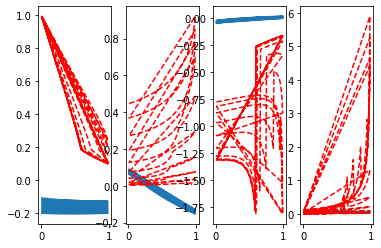

Step 1000 loss is 0.0005224545020610094
u loss is 0.00026167629403062165
p loss is 0.0002607782371342182
dudy loss is 0.0
dpdyloss is 0.0


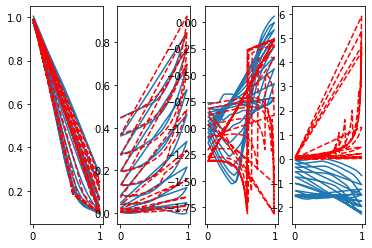

Step 2000 loss is 0.00018038725829683244
u loss is 0.00010250628110952675
p loss is 7.78809844632633e-05
dudy loss is 0.0
dpdyloss is 0.0


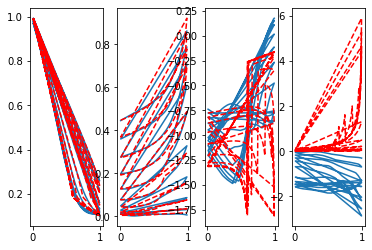

Step 3000 loss is 9.340945689473301e-05
u loss is 4.1722403693711385e-05
p loss is 5.1687053201021627e-05
dudy loss is 0.0
dpdyloss is 0.0


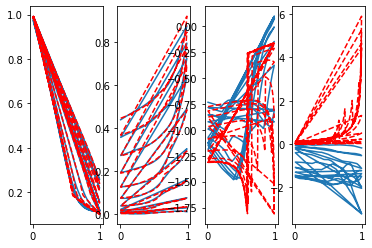

Step 4000 loss is 6.127663073129952e-05
u loss is 2.8706062948913313e-05
p loss is 3.257056960137561e-05
dudy loss is 0.0
dpdyloss is 0.0


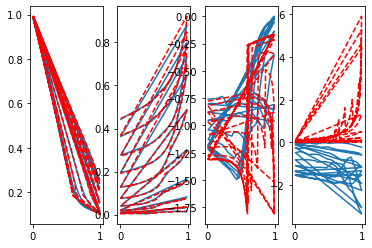

Step 5000 loss is 3.7050362152513117e-05
u loss is 1.9532795704435557e-05
p loss is 1.751756644807756e-05
dudy loss is 0.0
dpdyloss is 0.0


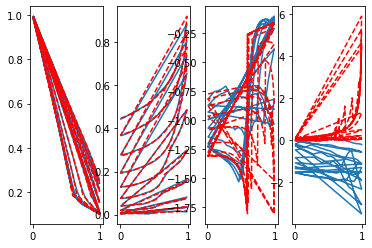

Step 6000 loss is 0.001530334702692926
u loss is 0.0014816829934716225
p loss is 4.865171649726108e-05
dudy loss is 0.0
dpdyloss is 0.0


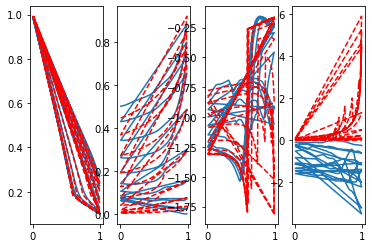

Step 7000 loss is 0.0006691045709885657
u loss is 0.0006254143663682044
p loss is 4.369020462036133e-05
dudy loss is 0.0
dpdyloss is 0.0


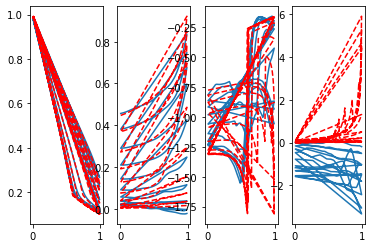

Step 8000 loss is 2.3359327315120026e-05
u loss is 1.4169098903948907e-05
p loss is 9.190227501676418e-06
dudy loss is 0.0
dpdyloss is 0.0


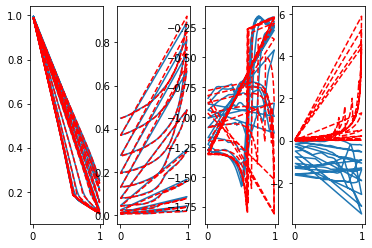

Step 9000 loss is 1.725522815831937e-05
u loss is 9.849300113273785e-06
p loss is 7.405928499792935e-06
dudy loss is 0.0
dpdyloss is 0.0


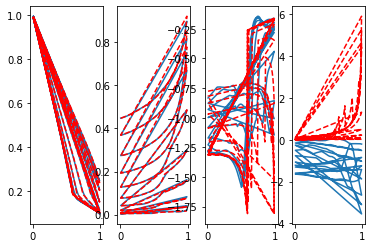

Step 10000 loss is 3.595015368773602e-05
u loss is 1.2388867617119104e-05
p loss is 2.3561286070616916e-05
dudy loss is 0.0
dpdyloss is 0.0


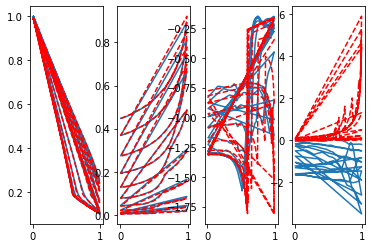

Step 11000 loss is 1.2470207366277464e-05
u loss is 7.619099960720632e-06
p loss is 4.851107860304182e-06
dudy loss is 0.0
dpdyloss is 0.0


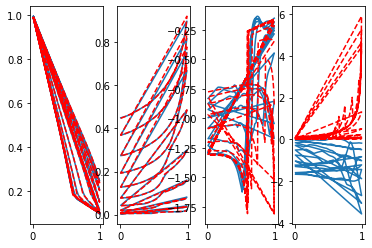

Step 12000 loss is 1.1581118997128215e-05
u loss is 6.982751983741764e-06
p loss is 4.598367013386451e-06
dudy loss is 0.0
dpdyloss is 0.0


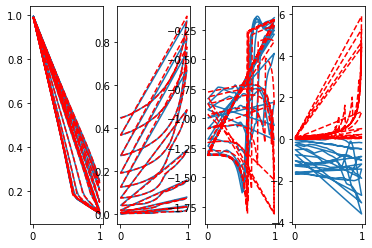

Step 13000 loss is 1.0592923899821471e-05
u loss is 6.272092832659837e-06
p loss is 4.3208310671616346e-06
dudy loss is 0.0
dpdyloss is 0.0


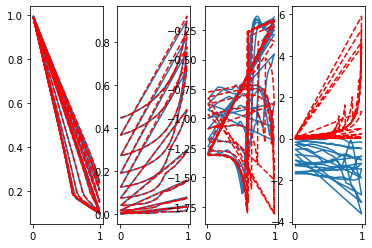

Step 14000 loss is 9.444288480153773e-06
u loss is 5.459769909066381e-06
p loss is 3.984518571087392e-06
dudy loss is 0.0
dpdyloss is 0.0


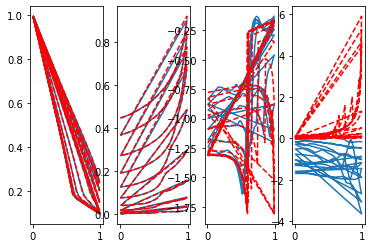

Step 15000 loss is 8.236382200266235e-06
u loss is 4.627846010407666e-06
p loss is 3.608535735111218e-06
dudy loss is 0.0
dpdyloss is 0.0


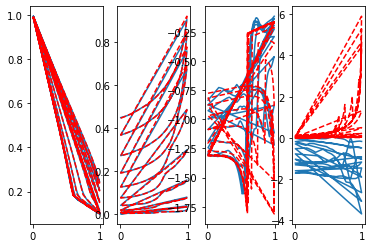

Step 16000 loss is 1.0775166629173327e-05
u loss is 7.416147127514705e-06
p loss is 3.3590192742849467e-06
dudy loss is 0.0
dpdyloss is 0.0


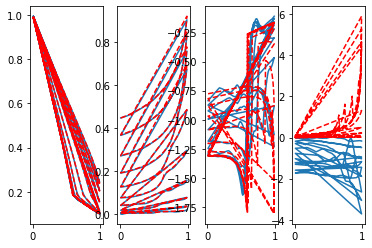

Step 17000 loss is 7.681515853619203e-06
u loss is 4.626179361366667e-06
p loss is 3.055336492252536e-06
dudy loss is 0.0
dpdyloss is 0.0


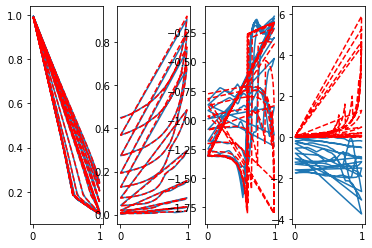

Step 18000 loss is 5.972178769297898e-06
u loss is 3.122888529105694e-06
p loss is 2.8492902401922038e-06
dudy loss is 0.0
dpdyloss is 0.0


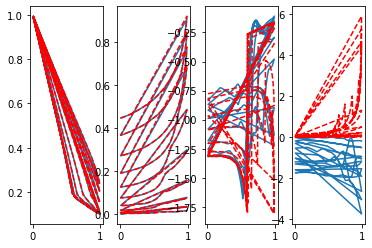

Step 19000 loss is 5.487911039381288e-06
u loss is 2.817305357893929e-06
p loss is 2.6706054541136837e-06
dudy loss is 0.0
dpdyloss is 0.0


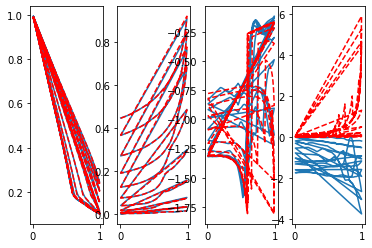

Step 20000 loss is 5.184424480830785e-06
u loss is 2.6552972940407926e-06
p loss is 2.529126959416317e-06
dudy loss is 0.0
dpdyloss is 0.0


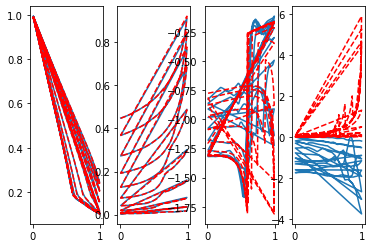

Step 21000 loss is 5.004598733648891e-06
u loss is 2.545161578382249e-06
p loss is 2.4594371552666416e-06
dudy loss is 0.0
dpdyloss is 0.0


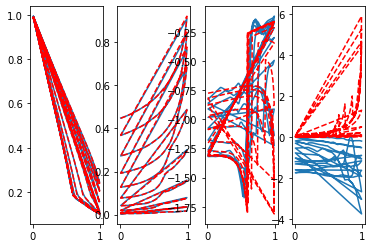

Step 22000 loss is 4.922092102788156e-06
u loss is 2.5007605017890455e-06
p loss is 2.4213316009991104e-06
dudy loss is 0.0
dpdyloss is 0.0


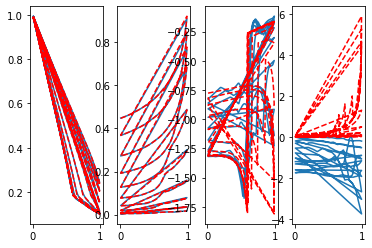

Step 23000 loss is 4.791459105035756e-06
u loss is 2.432260089335614e-06
p loss is 2.3591987883264665e-06
dudy loss is 0.0
dpdyloss is 0.0


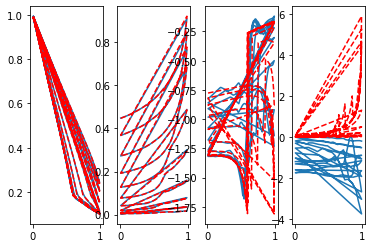

Step 24000 loss is 4.591326160152676e-06
u loss is 2.332118356207502e-06
p loss is 2.2592078039451735e-06
dudy loss is 0.0
dpdyloss is 0.0


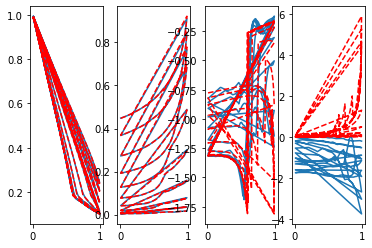

Step 25000 loss is 4.3184481910429895e-06
u loss is 2.2061067284084857e-06
p loss is 2.1123416900081793e-06
dudy loss is 0.0
dpdyloss is 0.0


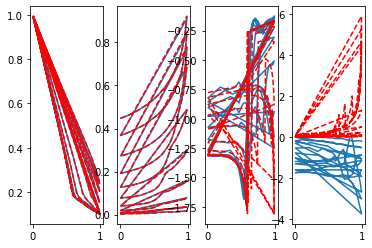

Step 26000 loss is 4.060052560816985e-06
u loss is 2.093515377055155e-06
p loss is 1.966537411135505e-06
dudy loss is 0.0
dpdyloss is 0.0


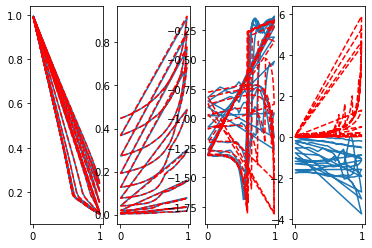

Step 27000 loss is 3.846968866128009e-06
u loss is 2.0054474134667544e-06
p loss is 1.8415215663480922e-06
dudy loss is 0.0
dpdyloss is 0.0


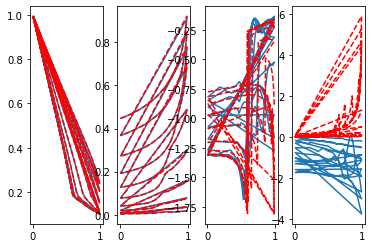

Step 28000 loss is 3.6439851101022214e-06
u loss is 1.9134708963974845e-06
p loss is 1.730514213704737e-06
dudy loss is 0.0
dpdyloss is 0.0


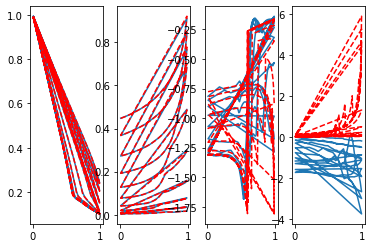

Step 29000 loss is 3.4821537155949045e-06
u loss is 1.8437667677062564e-06
p loss is 1.6383868342018104e-06
dudy loss is 0.0
dpdyloss is 0.0


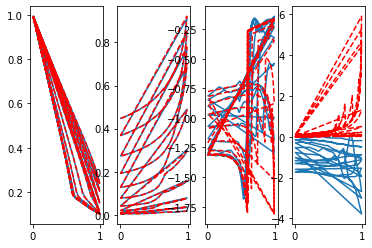

Step 30000 loss is 3.303317498648539e-06
u loss is 1.7570848740433576e-06
p loss is 1.5462327382920193e-06
dudy loss is 0.0
dpdyloss is 0.0


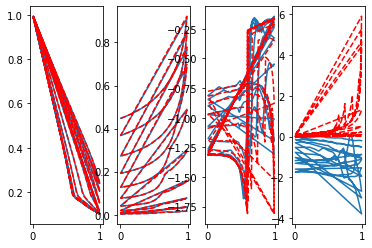

Step 31000 loss is 3.2834916510182666e-06
u loss is 1.7477931351095322e-06
p loss is 1.5356985159087344e-06
dudy loss is 0.0
dpdyloss is 0.0


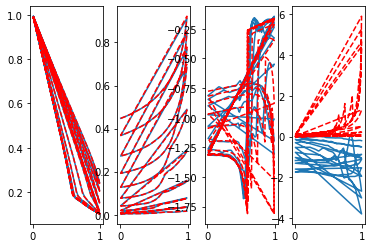

Step 32000 loss is 3.253452177887084e-06
u loss is 1.7337334838885e-06
p loss is 1.519718693998584e-06
dudy loss is 0.0
dpdyloss is 0.0


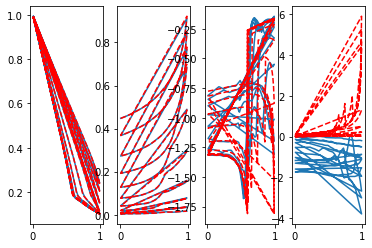

Step 33000 loss is 3.209249825886218e-06
u loss is 1.71297790529934e-06
p loss is 1.496271920586878e-06
dudy loss is 0.0
dpdyloss is 0.0


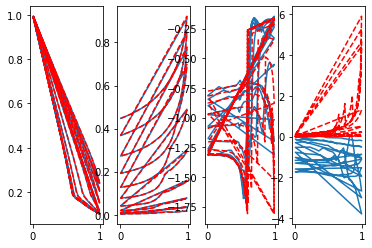

Step 34000 loss is 3.146603603454423e-06
u loss is 1.6832220808282727e-06
p loss is 1.4633815226261504e-06
dudy loss is 0.0
dpdyloss is 0.0


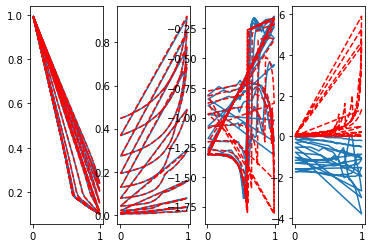

Step 35000 loss is 3.0624835289927432e-06
u loss is 1.6423563238276984e-06
p loss is 1.4201272051650449e-06
dudy loss is 0.0
dpdyloss is 0.0


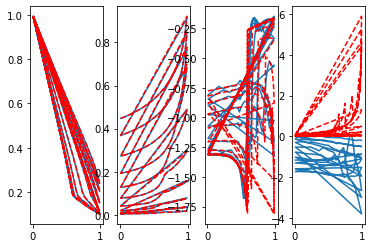

Step 36000 loss is 2.967455657199025e-06
u loss is 1.5950832903399714e-06
p loss is 1.372372253172216e-06
dudy loss is 0.0
dpdyloss is 0.0


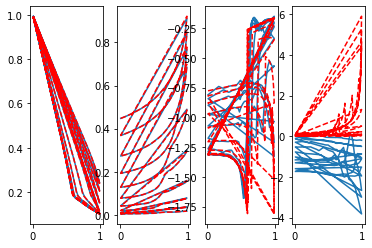

Step 37000 loss is 2.8761985504388576e-06
u loss is 1.5485537687709439e-06
p loss is 1.3276447816679138e-06
dudy loss is 0.0
dpdyloss is 0.0


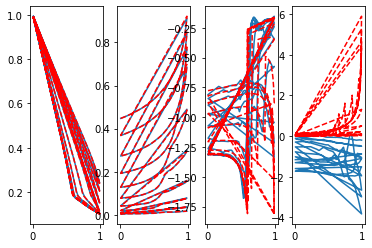

Step 38000 loss is 2.7905198294320144e-06
u loss is 1.5038397123134928e-06
p loss is 1.2866801171185216e-06
dudy loss is 0.0
dpdyloss is 0.0


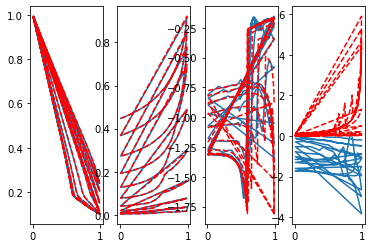

Step 39000 loss is 2.708985448407475e-06
u loss is 1.4605068372475216e-06
p loss is 1.2484784974731156e-06
dudy loss is 0.0
dpdyloss is 0.0


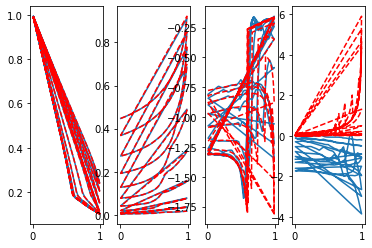

Step 40000 loss is 2.6321527002437506e-06
u loss is 1.4192735307005933e-06
p loss is 1.2128790558563196e-06
dudy loss is 0.0
dpdyloss is 0.0


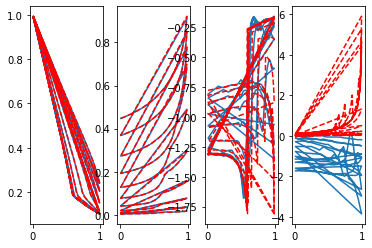

Step 41000 loss is 2.623585487526725e-06
u loss is 1.4146052080832305e-06
p loss is 1.2089802794434945e-06
dudy loss is 0.0
dpdyloss is 0.0


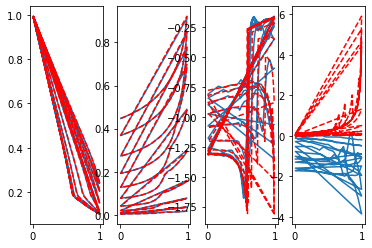

Step 42000 loss is 2.6128134322789265e-06
u loss is 1.4086361943554948e-06
p loss is 1.2041772379234317e-06
dudy loss is 0.0
dpdyloss is 0.0


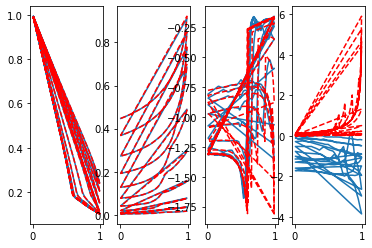

Step 43000 loss is 2.5999984245572705e-06
u loss is 1.40147756155784e-06
p loss is 1.1985207493125927e-06
dudy loss is 0.0
dpdyloss is 0.0


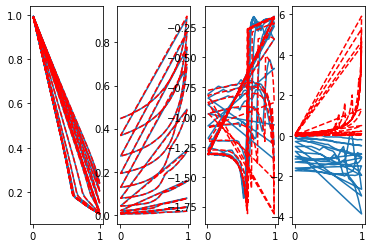

Step 44000 loss is 2.5854396881186403e-06
u loss is 1.3932234423918999e-06
p loss is 1.1922162457267405e-06
dudy loss is 0.0
dpdyloss is 0.0


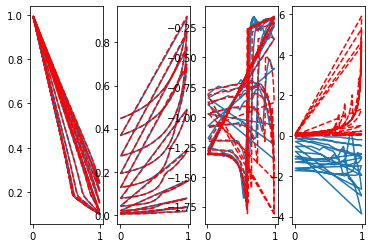

Step 45000 loss is 2.5696972443256527e-06
u loss is 1.3842183079759707e-06
p loss is 1.1854788226628443e-06
dudy loss is 0.0
dpdyloss is 0.0


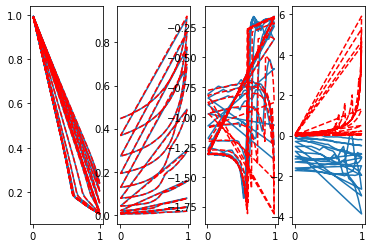

Step 46000 loss is 2.5532954168738797e-06
u loss is 1.374774797113787e-06
p loss is 1.178520506073255e-06
dudy loss is 0.0
dpdyloss is 0.0


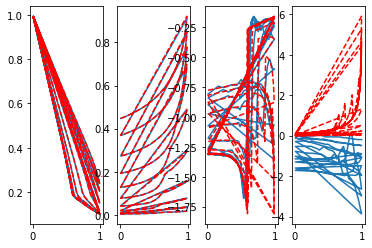

Step 47000 loss is 2.5367266971443314e-06
u loss is 1.3651711014972534e-06
p loss is 1.1715557093339157e-06
dudy loss is 0.0
dpdyloss is 0.0


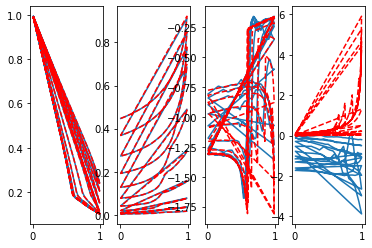

Step 48000 loss is 2.520265752536943e-06
u loss is 1.3556344811149756e-06
p loss is 1.1646311577351298e-06
dudy loss is 0.0
dpdyloss is 0.0


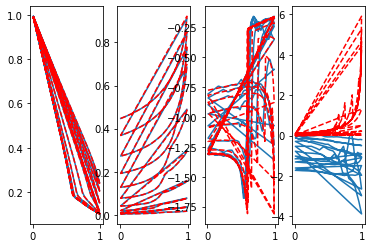

Step 49000 loss is 2.5039030333573464e-06
u loss is 1.346119006484514e-06
p loss is 1.1577840268728323e-06
dudy loss is 0.0
dpdyloss is 0.0


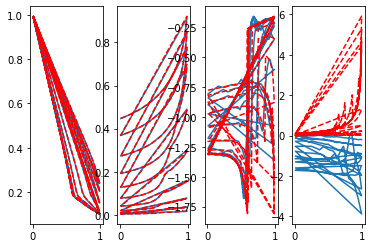

In [486]:
N_INPUTS = 2    # y and mu
N_OUTPUTS = 2   # p and u
N_ITER = 50000
conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS) 

ins_tensor = tf.convert_to_tensor(ins, dtype=tf.float32)

train(conduit_nn, ins_tensor, A, v_true, dvdy_true, parameter_range_conduit_loss)

In [180]:
A['Re'].shape

(400, 1)

# Test on unseen data




0.6666666666666666


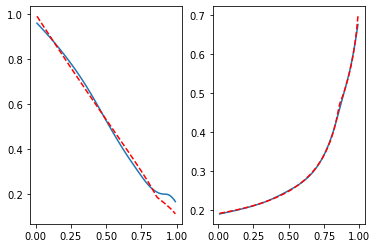

In [483]:
test_mu = 1e4
test_mu_log = np.ones_like(y)*np.log10(test_mu)/MAX_MU
print(test_mu_log[0,0])

test_in = np.concatenate([y,test_mu_log], axis=1)
test_out = conduit_nn(test_in).numpy()

p_pred = test_out[:,0]
u_pred = test_out[:,1]

A['mu'] = float(test_mu)
set_nondimensional_params(A)
[p_true,u_true, dpdy_true, dudy_true, B] = eng.get_simple_eruption(A,query_matlab, nargout=5);

plt.subplot(121)
plt.plot(y, p_pred)
plt.plot(y,mat_to_py(p_true), '--r')

plt.subplot(122)
plt.plot(y, u_pred)
plt.plot(y, mat_to_py(u_true), '--r')

plt.show()

# Do a simple MCMC

Let's say we know the exit velocity of the observed eruption, and assume we know all the parameters of the model except for the viscosity. Can we use MCMC do constrain the viscosity?

In [373]:
from mcmc import mcmc_engine # simple MCMC function I wrote
import importlib
importlib.reload(mcmc)

import time

To use the mcmc function we need:

1. G: A function that takes in the model parameters (here just a scalar equal to the normalized log of viscosity) and outputs the exit velocity
2. loglikelihood: A function that computes the log(likelihood)


In [479]:
def G_nn(normalized_mu,*args):
  # get a tensor to pass to the nn that queries the surface velocity given the viscosity 
  assert normalized_mu.shape == (1,), "Wrong size mu sent to G"
  
  normalized_mu = normalized_mu[0] # should be a 1-d array of one val
  model_in = np.array([[1,normalized_mu]])
  
  # run the tensor through the nn
  model_out = conduit_nn(model_in).numpy()
  
  # get the velocity
  u = model_out[0][1]
  
  return u

def loglikelihood_L2(G,x,data,sigma,*args):
  r = G(x,args) - data
  logL = -r**2/(2*sigma**2)
  return logL
  
  

In [431]:
start = time.time()
x_keep_nn, L_keep_nn, count_nn = mcmc_engine(G_nn,  loglikelihood_L2, data=0.7, x0=np.array([0.7]), xstep=.01, xbnds=np.array([[0.5,1]]), sigma=0.15, Niter=40000)
end = time.time()
print(f"That took {end-start} seconds")

That took 11.292632818222046 seconds


(array([328., 348., 363., 381., 357., 349., 412., 417., 459., 428., 436.,
        476., 461., 475., 467., 485., 447., 511., 516., 504., 608., 564.,
        599., 594., 613., 613., 673., 649., 699., 702., 708., 691., 705.,
        698., 752., 698., 766., 770., 807., 769., 737., 716., 703., 719.,
        682., 756., 787., 738., 763., 785., 776., 771., 706., 711., 667.,
        645., 632., 543., 586., 507., 524., 440., 356., 386., 326., 318.,
        258., 210., 162., 166., 123.,  84.,  89.,  87.,  39.,  33.,  29.,
         11.,  26.,  22.,  12.,  16.,   9.,   3.,   3.,   2.,   6.,   0.,
          5.,   3.,   4.,   3.,   3.,   2.,   4.,   0.,   2.,   2.,   1.,
          3.]),
 array([0.50000159, 0.50356648, 0.50713138, 0.51069627, 0.51426117,
        0.51782606, 0.52139096, 0.52495586, 0.52852075, 0.53208565,
        0.53565054, 0.53921544, 0.54278033, 0.54634523, 0.54991012,
        0.55347502, 0.55703992, 0.56060481, 0.56416971, 0.5677346 ,
        0.5712995 , 0.57486439, 0.57842929, 0.

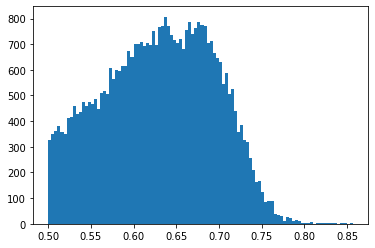

In [432]:
plt.hist(x_keep_nn,bins=100)

## Compare to matlab

In [476]:
query_matlab_mcmc = matlab.double([0.999])

def G_matlab(normalized_mu,*args):
  # get a tensor to pass to the nn that queries the surface velocity given the viscosity 
  assert normalized_mu.shape == (1,), "Wrong size mu sent to G"
  
  
  normalized_mu = normalized_mu[0] # should be a 1-d array of one val

  test_mu = 10**(normalized_mu*MAX_MU)
  
  A['mu'] = float(test_mu)
  set_nondimensional_params(A)
  [p_true,u_true, dpdy_true, dudy_true, B] = eng.get_simple_eruption(A,query_matlab_mcmc, nargout=5);
  
  return u_true

def loglikelihood_L2(G,x,data,sigma,*args):
  r = G(x,args) - data
  logL = -r**2/(2*sigma**2)
  return logL

In [374]:
start = time.time()
x_keep, L_keep, count = mcmc_engine(G,  loglikelihood_L2, data=0.7, x0=np.array([0.7]), xstep=.01, xbnds=np.array([[0.5,1]]), sigma=0.15, Niter=4000)
end = time.time()
print(f"That took {end-start} seconds")

That took 4297.508794546127 seconds


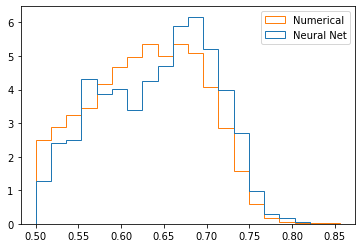

In [435]:
plt.hist([x_keep[:,0], x_keep_nn[:,0]],bins=20, histtype='step',density=True)
plt.legend(["Numerical", "Neural Net"])
plt.show()

In [481]:
mus = np.linspace(0.5,1,100)[:,np.newaxis]
nn = []
#mat = []
for i in range(max(mus.shape)):
  nn.append(G_nn(mus[i,:]))
  #mat.append(G_matlab(mus[i,:]))



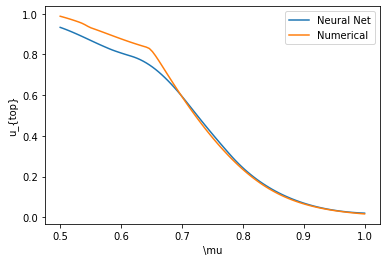

In [482]:
plt.plot(mus,nn)
plt.plot(mus,mat)
plt.legend(["Neural Net", "Numerical"])
plt.xlabel("\mu")
plt.ylabel("u_{top}")
plt.show()